# FINAL PROJECT - SOCIAL MEDIA - AML3204

##  IMPORTING LIBRARIES

In [186]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import json
from tqdm.notebook import tqdm

In [234]:
import warnings
warnings.filterwarnings("ignore")

## IMPORTING PROJECT DATA

In [189]:
try:
  !git clone https://github.com/mlgomez0/social_media_analytics
  !mv social_media_analytics/recommender_systems/data/* .
  !rm -rf social_media_analytics
except:
  print("The files are already imported")

Cloning into 'social_media_analytics'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 12 (delta 0), reused 9 (delta 0), pack-reused 0
Receiving objects: 100% (12/12), 17.63 MiB | 18.46 MiB/s, done.


## 1. COLLABORATIVE FILTERING: MATRIX FACTORIZATION

### READING DATA

In [190]:
# Reading data to get Ratings
head = ["user_id","item_id","rating","timestamp"]
df_rating = pd.read_csv("u.data",names=head,sep="\t")

In [191]:
df_rating

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [192]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [193]:
df_rating.user_id.nunique()

943

In [194]:
df_rating.item_id.nunique()

1682

In [195]:
df_rating.shape

(100000, 4)

In [196]:
df_rating["datetime"] = df_rating["timestamp"].apply(lambda x: datetime.datetime.fromtimestamp(x))

In [197]:
df_pivoted = df_rating.pivot( index="user_id" , columns="item_id" , values="rating" )
df_pivoted

item_id  1     2     3     4     5     6     7     8     9     10    11    \
user_id                                                                     
1         5.0   3.0   4.0   3.0   3.0   5.0   4.0   1.0   5.0   3.0   2.0   
2         4.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   2.0   NaN   
3         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   4.0   
5         4.0   3.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
939       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   5.0   NaN   NaN   
940       NaN   NaN   NaN   2.0   NaN   NaN   4.0   5.0   3.0   NaN   NaN   
941       5.0   NaN   NaN   NaN   NaN   NaN   4.0   NaN   NaN   NaN   NaN   
942       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
943       NaN   5.0   NaN   NaN   NaN   NaN   NaN   NaN   3.0   NaN   4.0   

item_id  12    13    14    15    16    17    18    19    20    21    22    \
user_id                                                                     
1         5.0   5.0   5.0   5.0   5.0   3.0   4.0   5.0   4.0   1.0   4.0   
2         NaN   4.0   4.0   NaN   NaN   NaN   NaN   3.0   NaN   NaN   NaN   
3         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
5         NaN   NaN   NaN   NaN   NaN   4.0   NaN   NaN   NaN   3.0   NaN   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
939       NaN   NaN   NaN   5.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
940       4.0   NaN   3.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
941       NaN   NaN   NaN   4.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
942       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
943       5.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   4.0   

item_id  23    24    25    26    27    28    29    30    31    32    33    \
user_id                                                                     
1         4.0   3.0   4.0   3.0   2.0   4.0   1.0   3.0   3.0   5.0   4.0   
2         NaN   NaN   4.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
5         NaN   4.0   3.0   NaN   NaN   NaN   4.0   NaN   NaN   NaN   NaN   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
939       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
940       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
941       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
942       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   5.0   NaN   NaN   
943       4.0   4.0   NaN   NaN   4.0   4.0   NaN   NaN   4.0   NaN   NaN   

item_id  34    35    36    37    38    39    40    41    42    43    44    \
user_id                                                                     
1         2.0   1.0   2.0   2.0   3.0   4.0   3.0   2.0   5.0   4.0   5.0   
2         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
5         NaN   NaN   NaN   NaN   NaN   NaN   4.0   NaN   5.0   NaN   NaN   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
939       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
940       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
941       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
942       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
943       NaN   NaN   NaN   NaN   3.0   NaN   NaN   4.0   5.0   NaN   

### ANALYSING THE SPARSE MATRIX

In [198]:
# Getting the number of users and items from df_rating
n_users = len(df_rating.user_id.unique())
n_items = len(df_rating.item_id.unique())
print("Number of unique users:", n_users)
print("Number of unique movies:", n_items)
print("The full rating matrix will have:", n_users*n_items, 'elements.')
print('----------')
print("Number of ratings:", len(df_rating))
print("Therefore: ", len( df_rating ) / ( n_users * n_items ) * 100, '% of the matrix is filled.')
### Analizing the sparse matrix
print("We have an incredibly sparse matrix to work with here.")
print("And... as you can imagine, as the number of users and products grow, the number of elements will increase by n*2")
print("You are going to need a lot of memory to work with global scale... storing a full matrix in memory would be a challenge.")
print("One advantage here is that matrix factorization can realize the rating matrix implicitly, thus we don't need all the data")

Number of unique users: 943
Number of unique movies: 1682
The full rating matrix will have: 1586126 elements.
----------
Number of ratings: 100000
Therefore:  6.304669364224531 % of the matrix is filled.
We have an incredibly sparse matrix to work with here.
And... as you can imagine, as the number of users and products grow, the number of elements will increase by n*2
You are going to need a lot of memory to work with global scale... storing a full matrix in memory would be a challenge.
One advantage here is that matrix factorization can realize the rating matrix implicitly, thus we don't need all the data


### MATRIX FACTORIZATION MODEL

#### DATASET TO TENSORS

In [199]:
data = df_rating.copy()

user_ids = data['user_id'].unique()
item_ids = data['item_id'].unique()

user_id_map = {id: idx for idx, id in enumerate(user_ids)}
item_id_map = {id: idx for idx, id in enumerate(item_ids)}

data['user_id'] = data['user_id'].map(user_id_map)
data['item_id'] = data['item_id'].map(item_id_map)

user_id_reverse_map = {idx: id for id, idx in user_id_map.items()}
item_id_reverse_map = {idx: id for id, idx in item_id_map.items()}

n_users = len(user_ids)
n_items = len(item_ids)

# Split data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

class RatingsDataset(Dataset):
    def __init__(self, ratings):
        self.ratings = ratings

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        user_id = self.ratings.iloc[idx, 0]
        item_id = self.ratings.iloc[idx, 1]
        rating = self.ratings.iloc[idx, 2]
        return user_id, item_id, rating

train_dataset = RatingsDataset(train_data)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [200]:
train_data.shape

(80000, 5)

In [201]:
test_data.shape

(20000, 5)

In [202]:
user_id_map[196]

0

In [203]:
user_id_reverse_map[0]

196

#### MODEL

In [204]:
class RecSysMF(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=20):
        super(RecSysMF, self).__init__()
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.item_factors = nn.Embedding(n_items, n_factors)

    def forward(self, user, item):
        user_embedding = self.user_factors(user)
        item_embedding = self.item_factors(item)
        return (user_embedding * item_embedding).sum(1)

#### MODEL EXPERIMENTS

In [205]:
def plot_training_epochs(epoch_results, label, range):
  plt.plot(epoch_results)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title(f'Loss vs Epochs, {label}')

  plt.xticks(np.arange(1, range))

  plt.show()

In [206]:
def train_recommender_mf(model, train_dataloader, criterion, optimizer, n_epochs):
  epoch_results = []
  for epoch in tqdm(range(n_epochs)):
      model.train()
      total_loss = 0
      for user, item, rating in train_dataloader:
          user = user.long()
          item = item.long()
          rating = rating.float()

          optimizer.zero_grad()
          prediction = model(user, item)
          loss = criterion(prediction, rating)
          loss.backward()
          optimizer.step()

          total_loss += loss.item()
      epoch_loss = total_loss / len(train_dataloader)
      epoch_results.append(epoch_loss)
      print(f'Epoch {epoch+1}, Loss: {epoch_loss}')
  return epoch_results

In [207]:
def get_mse_rmse(model, test_users, test_items, test_ratings):
  model.eval()
  with torch.no_grad():
      test_predictions = model(test_users, test_items).numpy()

  mse = mean_squared_error(test_ratings, test_predictions)
  rmse = np.sqrt(mse)
  print(f'Test MSE: {mse}, Test RMSE: {rmse}')

In [208]:
def recommend_movies(model, user_id, items_to_predict, user_id_map, item_id_map, item_id_reverse_map, top_n=10):

    user_idx = user_id_map[user_id]


    items_to_predict_idx = list([item_id_map[idx] for idx in items_to_predict])


    user_tensor = torch.tensor([user_idx] * len(items_to_predict_idx))

    item_tensor = torch.tensor(items_to_predict_idx)

    model.eval()
    with torch.no_grad():
        predictions = model(user_tensor, item_tensor)

    _, top_indices = torch.topk(predictions, top_n)

    recommended_item_ids = [item_id_reverse_map[items_to_predict_idx[idx]] for idx in top_indices]

    return recommended_item_ids

In [209]:
def get_top_rated_movies(user_id, data, top_n=10):
    user_data = data[data['user_id'] == user_id]
    top_rated_items = user_data.sort_values(by='rating', ascending=False).head(top_n)
    return top_rated_items['item_id'].values

In [210]:
def get_precision_at_k(test_data, model, user_id_map, item_id_map, item_id_reverse_map, top_n=10):
  test_users = test_data['user_id'].unique()
  precisions = []

  for user_id in test_users:
    items_to_predict = test_data[test_data['user_id'] == user_id]['item_id'].values
    if len(items_to_predict) >= 20:
      try:
        items_to_predict = random.sample(list(items_to_predict), 20)
        # Get top N recommended movies for the selected user
        recommended_movies = recommend_movies(model, user_id, items_to_predict, user_id_map, item_id_map, item_id_reverse_map, top_n)

        # Get top N rated movies for the selected user from the test set
        top_rated_movies = get_top_rated_movies(user_id, test_data, top_n)

        intersection = set(recommended_movies) & set(top_rated_movies)

        precision = len(intersection) / len(recommended_movies)

        precisions.append(precision)
      except:
        pass
  average_precision = np.mean(precisions)
  print(f"Average Precision: {average_precision}")
  return average_precision

In [211]:
test_users = torch.LongTensor(test_data['user_id'].values)
test_items = torch.LongTensor(test_data['item_id'].values)
test_ratings = test_data['rating'].values

##### Experiment 1: 20 latent factors

In [212]:
model = RecSysMF(n_users, n_items)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
n_epochs = 10

In [213]:
epoch_results_e1 = train_recommender_mf(model, train_dataloader, criterion, optimizer, n_epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Loss: 21.544146644592285
Epoch 2, Loss: 3.722781006813049
Epoch 3, Loss: 1.2689343447685242
Epoch 4, Loss: 0.9654100021362305
Epoch 5, Loss: 0.9137029368400573
Epoch 6, Loss: 0.9005992865562439
Epoch 7, Loss: 0.8731844363451005
Epoch 8, Loss: 0.8320536902904511
Epoch 9, Loss: 0.7932114253759384
Epoch 10, Loss: 0.7647286297559738


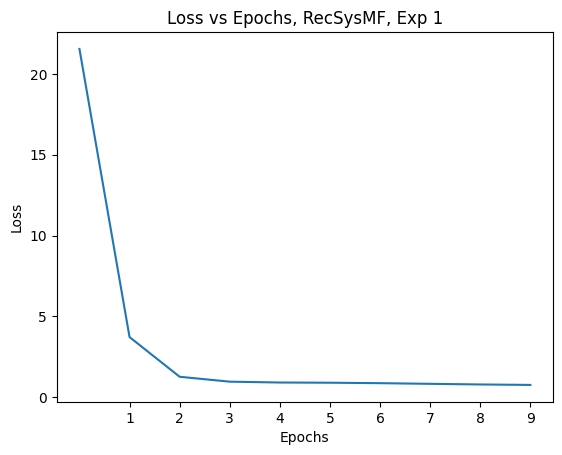

In [214]:
plot_training_epochs(epoch_results_e1, "RecSysMF, Exp 1", 10)

In [215]:
get_mse_rmse(model, test_users, test_items, test_ratings)

Test MSE: 1.4474154616042214, Test RMSE: 1.203085808080297


In [216]:
get_precision_at_k(test_data, model, user_id_map, item_id_map, item_id_reverse_map, top_n=10)

Average Precision: 0.29169054441260744


0.29169054441260744

##### Experiment 2: 10 latent factors

In [ ]:
model = RecSysMF(n_users, n_items, n_factors=10)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
n_epochs = 10

In [ ]:
epoch_results_e2 = train_recommender_mf(model, train_dataloader, criterion, optimizer, n_epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Loss: 9.948130237102509
Epoch 2, Loss: 1.6264090532779694
Epoch 3, Loss: 1.0234511385202407
Epoch 4, Loss: 0.9219458769798279
Epoch 5, Loss: 0.8822348467826844
Epoch 6, Loss: 0.8465502682685853
Epoch 7, Loss: 0.8155757425308228
Epoch 8, Loss: 0.7904084538459778
Epoch 9, Loss: 0.7730131592988968
Epoch 10, Loss: 0.7576974129438401


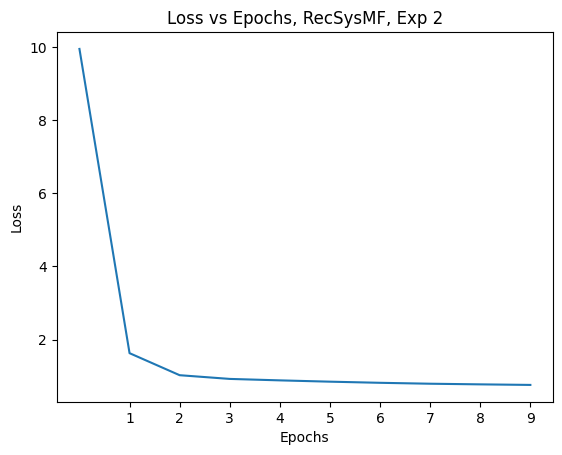

In [ ]:
plot_training_epochs(epoch_results_e2, "RecSysMF, Exp 2", 10)

In [ ]:
get_mse_rmse(model, test_users, test_items, test_ratings)

Test MSE: 1.1618563385311804, Test RMSE: 1.0778944004545068


In [ ]:
get_precision_at_k(test_data, model, user_id_map, item_id_map, item_id_reverse_map, top_n=10)

Average Precision: 0.2922636103151863


0.2922636103151863

##### Experiment 3: 5 latent factors

In [ ]:
model = RecSysMF(n_users, n_items, n_factors=5)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
n_epochs = 10

In [ ]:
epoch_results_e3 = train_recommender_mf(model, train_dataloader, criterion, optimizer, n_epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Loss: 14.633669044876099
Epoch 2, Loss: 2.671492530012131
Epoch 3, Loss: 1.067520488357544
Epoch 4, Loss: 0.9546612020492554
Epoch 5, Loss: 0.923017236661911
Epoch 6, Loss: 0.8935778520107269
Epoch 7, Loss: 0.8694359095573425
Epoch 8, Loss: 0.8517216234207153
Epoch 9, Loss: 0.8378912692070007
Epoch 10, Loss: 0.825892777967453


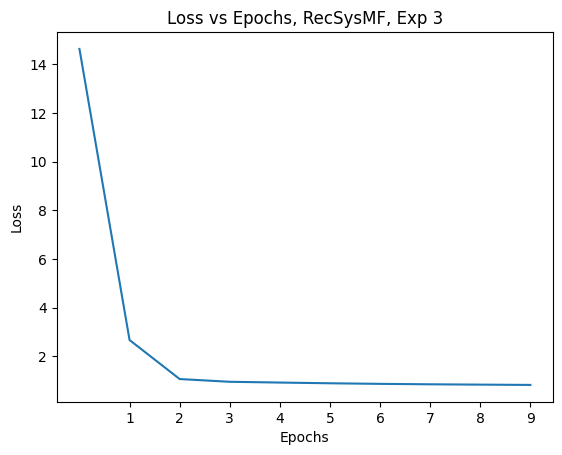

In [ ]:
plot_training_epochs(epoch_results_e3, "RecSysMF, Exp 3", 10)

In [ ]:
get_mse_rmse(model, test_users, test_items, test_ratings)

Test MSE: 1.0278763849120365, Test RMSE: 1.0138423866223174


In [ ]:
get_precision_at_k(test_data, model, user_id_map, item_id_map, item_id_reverse_map, top_n=10)

Average Precision: 0.2971264367816092


0.2971264367816092

##### Experiment 4: 5 latent factors, 20 epochs

In [ ]:
model = RecSysMF(n_users, n_items, n_factors=5)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
n_epochs = 20

In [ ]:
epoch_results_e4 = train_recommender_mf(model, train_dataloader, criterion, optimizer, n_epochs)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, Loss: 14.752894131469727
Epoch 2, Loss: 3.1347483803749085
Epoch 3, Loss: 1.1167687235355377
Epoch 4, Loss: 0.9445480266094207
Epoch 5, Loss: 0.8935106559276581
Epoch 6, Loss: 0.8596635187149048
Epoch 7, Loss: 0.8325175229549407
Epoch 8, Loss: 0.8152922677516937
Epoch 9, Loss: 0.8006229231357574
Epoch 10, Loss: 0.7928981729269028
Epoch 11, Loss: 0.784765380358696
Epoch 12, Loss: 0.780393087553978
Epoch 13, Loss: 0.7758676970005035
Epoch 14, Loss: 0.7741401802301406
Epoch 15, Loss: 0.7717434050083161
Epoch 16, Loss: 0.7687186263799667
Epoch 17, Loss: 0.7649457057476043
Epoch 18, Loss: 0.7660296905994415
Epoch 19, Loss: 0.7632091667890548
Epoch 20, Loss: 0.7604252881765365


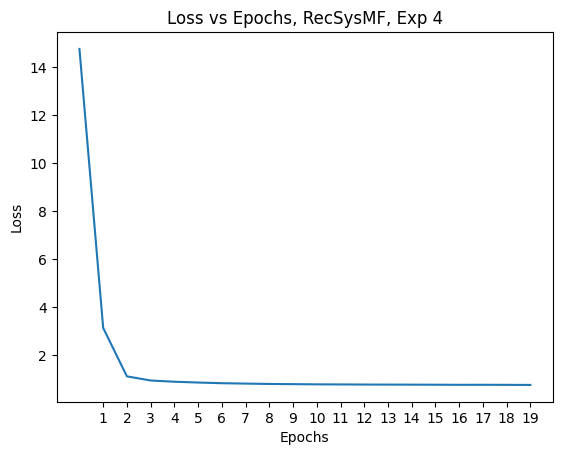

In [ ]:
plot_training_epochs(epoch_results_e4, "RecSysMF, Exp 4", 20)

In [ ]:
get_mse_rmse(model, test_users, test_items, test_ratings)

Test MSE: 1.0308958107645754, Test RMSE: 1.015330394878719


In [ ]:
get_precision_at_k(test_data, model, user_id_map, item_id_map, item_id_reverse_map, top_n=10)

Average Precision: 0.29482758620689653


0.29482758620689653

## 2. HYBRID RECOMMENDER SYSTEM

### DATASET PREPARATION


#### Sentiment Analysis

In [217]:
df = pd.read_csv("sentiment_analysis_final2.csv")

In [218]:
df['comments'] = df.loc[:, '0':'19'].values.tolist()

In [219]:
df.shape

(1677, 24)

In [220]:
do_sentiment_analysis = False

In [221]:
# function to get the sentiment analysis for the comments in each movie using Hugging Face transformers

def get_sentiment(comments):
  sentiment_classifier = pipeline(
        model="lxyuan/distilbert-base-multilingual-cased-sentiments-student"
    )
  result = []
  for comments_list in comments:
    scores = []
    for comment in comments_list:
      if len(scores) > 100:
        break
      try:
        sentiment = sentiment_classifier(comment, truncation=True)
        sentiment = sentiment[0]
        scores.append({sentiment['label']: sentiment['score']})
      except Exception as e:
        print(f"There was an error getting sentiment {e}")
    result.append(scores)
  return result

In [222]:
# Process the columns in batches
def process_sentiments(batch_size, path, data):
  result = []
  for start in range(0, len(data), batch_size):
    end = start + batch_size
    batch = data.iloc[start:end]
    result += get_sentiment(batch['comments'])
    with open(path, 'w') as file:
      json.dump(result, file)
  return result

In [223]:
# do sentiment analysis or import file with analysis made before
if do_sentiment_analysis:
  process_sentiments(100, 'sentiments.json', df)

In [224]:
def get_sentiment_scores(sentiments):
  positive = []
  negative = []
  for sentiment in sentiments:
    positive_count = 0
    negative_count = 0
    positive_sum = 0
    negative_sum = 0
    for item in sentiment:
      if item and 'negative' in item.keys():
        negative_count += 1
        negative_sum += item['negative']
      elif item and 'positive' in item.keys():
        positive_count += 1
        positive_sum += item['positive']
      else:
        continue
    if not positive_count:
      positive.append(None)
    else:
      positive.append(positive_sum / positive_count)
    if not negative_count:
      negative.append(None)
    else:
      negative.append(negative_sum / negative_count)
  return positive, negative

In [226]:
sentiments = pd.read_json('sentiments.json').values

In [227]:
len(sentiments)

1677

In [228]:
positive, _ = get_sentiment_scores(sentiments)

#### Final Dataset

In [229]:
df_items = pd.read_csv('u.item', sep='|', header=None, encoding='latin-1')

In [230]:
df_items.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [231]:
df_items.shape

(1682, 24)

In [235]:
data = df_items.iloc[:1677, :]

In [236]:
data['item_id'] = df_items.iloc[:1677, 0]
data['positive'] = positive

In [237]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,item_id,positive
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.724138
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0.725342
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,0.585432
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,4,0.668227
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,5,0.670225


In [238]:
data.drop(columns=[0,1, 2,3,4], inplace=True)

In [239]:
data.head()

,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,item_id,positive
0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.724138
1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0.725342
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,0.585432
3,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,4,0.668227
4,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,5,0.670225


In [240]:
data.shape

(1677, 21)

In [241]:
df_genre = pd.read_csv('u.genre', sep='|', header=None, encoding='latin-1')

In [242]:
def add_five(x):
  return x + 5

In [243]:
df_genre.iloc[:, 1] = df_genre.iloc[:, 1].apply(add_five)

In [244]:
df_genre

,0,1
0,unknown,5
1,Action,6
2,Adventure,7
3,Animation,8
4,Children's,9
5,Comedy,10
6,Crime,11
7,Documentary,12
8,Drama,13
9,Fantasy,14


In [245]:
data.isna().sum()

,0
5,0
6,0
7,0
8,0
9,0
10,0
11,0
12,0
13,0
14,0


In [246]:
data.dropna(inplace=True)

In [247]:
data.isna().sum()

,0
5,0
6,0
7,0
8,0
9,0
10,0
11,0
12,0
13,0
14,0


In [248]:
head = ["user_id","item_id","rating","timestamp"]
df_user_rating = pd.read_csv("u.data",names=head,sep="\t")

In [249]:
df_user_rating.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


#### Merge the datasets

In [250]:
dataset = pd.merge(data, df_user_rating, on='item_id')

In [251]:
dataset.head()

,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,item_id,positive,user_id,rating,timestamp
0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.724138,308,4,887736532
1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.724138,287,5,875334088
2,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.724138,148,4,877019411
3,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.724138,280,4,891700426
4,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.724138,66,3,883601324


In [252]:
dataset.shape

(99397, 24)

In [253]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99397 entries, 0 to 99396
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   5          99397 non-null  int64  
 1   6          99397 non-null  int64  
 2   7          99397 non-null  int64  
 3   8          99397 non-null  int64  
 4   9          99397 non-null  int64  
 5   10         99397 non-null  int64  
 6   11         99397 non-null  int64  
 7   12         99397 non-null  int64  
 8   13         99397 non-null  int64  
 9   14         99397 non-null  int64  
 10  15         99397 non-null  int64  
 11  16         99397 non-null  int64  
 12  17         99397 non-null  int64  
 13  18         99397 non-null  int64  
 14  19         99397 non-null  int64  
 15  20         99397 non-null  int64  
 16  21         99397 non-null  int64  
 17  22         99397 non-null  int64  
 18  23         99397 non-null  int64  
 19  item_id    99397 non-null  int64  
 20  positi

#### Prepare dataset

In [254]:
# Encode user_id and item_id to numerical indices for the model
user_id_map = {id: idx for idx, id in enumerate(dataset['user_id'].unique())}
item_id_map = {id: idx for idx, id in enumerate(dataset['item_id'].unique())}
user_id_reverse_map = {idx: id for id, idx in user_id_map.items()}
item_id_reverse_map = {idx: id for id, idx in item_id_map.items()}
dataset['user_idx'] = dataset['user_id'].map(user_id_map)
dataset['item_idx'] = dataset['item_id'].map(item_id_map)


In [255]:
dataset.head()

,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,item_id,positive,user_id,rating,timestamp,user_idx,item_idx
0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.724138,308,4,887736532,0,0
1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.724138,287,5,875334088,1,0
2,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.724138,148,4,877019411,2,0
3,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.724138,280,4,891700426,3,0
4,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.724138,66,3,883601324,4,0


In [256]:
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

In [257]:
genre_columns = [i for i in range(5, 24)]

In [258]:
class RecommenderDataset(Dataset):
    def __init__(self, data, genre_columns):
        self.user_idx = torch.tensor(data['user_idx'].values, dtype=torch.long)
        self.item_idx = torch.tensor(data['item_idx'].values, dtype=torch.long)
        self.ratings = torch.tensor(data['rating'].values, dtype=torch.float32)
        self.genres = torch.tensor(data[genre_columns].values, dtype=torch.float32)
        self.sentiment = torch.tensor(data['positive'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.user_idx)

    def __getitem__(self, idx):
        return (self.user_idx[idx], self.item_idx[idx], self.ratings[idx], self.genres[idx], self.sentiment[idx])

train_dataset = RecommenderDataset(train_data, genre_columns)
test_dataset = RecommenderDataset(test_data, genre_columns)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

### MODEL

In [259]:
class HybridRecSys(nn.Module):
    def __init__(self, num_users, num_items, num_genres, embedding_dim):
        super(HybridRecSys, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.genre_embedding = nn.Linear(num_genres, embedding_dim)
        self.sentiment_fc = nn.Linear(1, embedding_dim)

        self.fc1 = nn.Linear(embedding_dim * 4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

        self.relu = nn.ReLU()

    def forward(self, user, item, genres, sentiment):
        user_embedded = self.user_embedding(user)
        item_embedded = self.item_embedding(item)
        genre_embedded = self.relu(self.genre_embedding(genres))
        sentiment_embedded = self.relu(self.sentiment_fc(sentiment.unsqueeze(1)))

        x = torch.cat([user_embedded, item_embedded, genre_embedded, sentiment_embedded], dim=-1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x.squeeze()

In [260]:
def train_hybrid_recommender(model, dataloader, criterion, optimizer, num_epochs):
  losses = []
  for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0
      for user, item, rating, genres, sentiment in dataloader:
          optimizer.zero_grad()

          outputs = model(user, item, genres, sentiment)
          loss = criterion(outputs, rating)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
      avg_loss = running_loss / len(dataloader)
      losses.append(avg_loss)
      print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}')
  return losses

#### EXPERIMENTS

In [261]:
def get_mse_rmse_hybrid(model, test_ratings, test_users, test_items, test_genres, test_sentiments):
  model.eval()
  with torch.no_grad():
      test_predictions = model(test_users, test_items, test_genres, test_sentiments).numpy()

  mse = mean_squared_error(test_ratings, test_predictions)
  rmse = np.sqrt(mse)
  print(f'Test MSE: {mse}, Test RMSE: {rmse}')

In [262]:
def recommend_movies_hybrid(model, user_id, items_to_predict, genre_data, sentiment_data, user_id_map, item_id_map, item_id_reverse_map, top_n=10):

    user_idx = user_id_map[user_id]


    items_to_predict_idx = list([item_id_map[idx] for idx in items_to_predict])


    user_tensor = torch.tensor([user_idx] * len(items_to_predict_idx))

    item_tensor = torch.tensor(items_to_predict_idx)

    # Extract genres and sentiments for the items to predict
    genre_tensor = torch.FloatTensor(genre_data)
    sentiment_tensor = torch.FloatTensor(sentiment_data)

    model.eval()
    with torch.no_grad():
        predictions = model(user_tensor, item_tensor, genre_tensor, sentiment_tensor)

    _, top_indices = torch.topk(predictions, top_n)

    recommended_item_ids = [item_id_reverse_map[items_to_predict_idx[idx]] for idx in top_indices]

    return recommended_item_ids

In [263]:
def get_precision_at_k_hybrid(test_data, model, user_id_map, item_id_map, item_id_reverse_map, top_n=10):
  test_users = test_data['user_id'].unique()
  precisions = []

  for user_id in test_users:
    items_to_predict = test_data[test_data['user_id'] == user_id]['item_id'].values
    if len(items_to_predict) >= 20:
      try:
        items_to_predict = sorted(random.sample(list(items_to_predict), 20))
        relevant_cols = ['item_id'] + genre_columns + ['positive']
        filtered_data = test_data[test_data['item_id'].isin(items_to_predict)]
        sorted_filtered = filtered_data.sort_values(by='item_id')
        final_data = sorted_filtered[relevant_cols].drop_duplicates()
        genre_data = final_data[genre_columns].values
        sentiment_data = final_data['positive'].values
        # Get top N recommended movies for the selected user
        recommended_movies = recommend_movies_hybrid(model, user_id, items_to_predict, genre_data, sentiment_data, user_id_map, item_id_map, item_id_reverse_map, top_n)
        # Get top N rated movies for the selected user from the test set
        top_rated_movies = get_top_rated_movies(user_id, test_data, top_n)

        intersection = set(recommended_movies) & set(top_rated_movies)

        precision = len(intersection) / len(recommended_movies)

        precisions.append(precision)
      except:
        pass
  average_precision = np.mean(precisions)
  print(f"Average Precision: {average_precision}")
  return average_precision

In [264]:
test_users = torch.LongTensor(test_data['user_idx'].values)
test_items = torch.LongTensor(test_data['item_idx'].values)
test_ratings = test_data['rating'].values
test_genres = torch.FloatTensor(test_data[genre_columns].values)
test_sentiments = torch.FloatTensor(test_data['positive'].values)

In [265]:
num_users = len(user_id_map)
num_items = len(item_id_map)
num_genres = len(genre_columns)

##### Exp 1: 50 embedding dim, 10 epochs

In [266]:
embedding_dim = 50
num_epochs = 10

model = HybridRecSys(num_users, num_items, num_genres, embedding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses_e1 = train_hybrid_recommender(model, train_dataloader, criterion, optimizer, num_epochs)

Epoch 1/10, Loss: 1.2202593757563411
Epoch 2/10, Loss: 0.9487327062019109
Epoch 3/10, Loss: 0.8882671796978239
Epoch 4/10, Loss: 0.8542195728059172
Epoch 5/10, Loss: 0.8271911954889352
Epoch 6/10, Loss: 0.8056530262420759
Epoch 7/10, Loss: 0.7832924244582221
Epoch 8/10, Loss: 0.7592331045880398
Epoch 9/10, Loss: 0.7356746349234976
Epoch 10/10, Loss: 0.7094634892666234


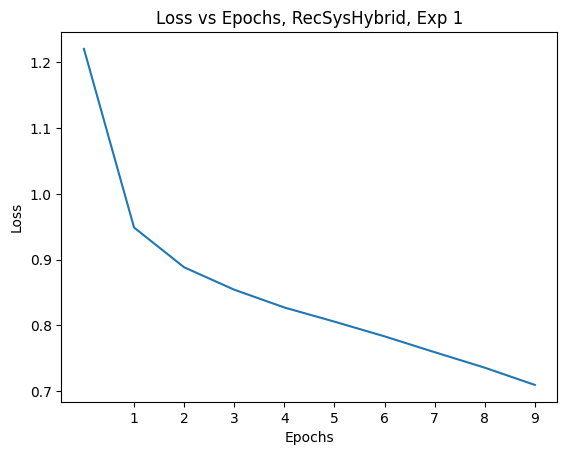

In [267]:
plot_training_epochs(losses_e1, "RecSysHybrid, Exp 1", 10)

In [268]:
get_mse_rmse_hybrid(model, test_ratings, test_users, test_items, test_genres, test_sentiments)

Test MSE: 0.9528970951692494, Test RMSE: 0.9761644816163152


In [269]:
get_precision_at_k_hybrid(test_data, model, user_id_map, item_id_map, item_id_reverse_map, top_n=10)

Average Precision: 0.39192200557103063


0.39192200557103063

##### Exp 2: 50 embedding dim, 20 epochs

In [159]:
embedding_dim = 50
num_epochs = 20

model = HybridRecSys(num_users, num_items, num_genres, embedding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses_e2 = train_hybrid_recommender(model, train_dataloader, criterion, optimizer, num_epochs)

Epoch 1/20, Loss: 1.278715685501467
Epoch 2/20, Loss: 0.9557032248759021
Epoch 3/20, Loss: 0.896017143324509
Epoch 4/20, Loss: 0.863549336131695
Epoch 5/20, Loss: 0.8399725739790946
Epoch 6/20, Loss: 0.8155812933046014
Epoch 7/20, Loss: 0.7948518587952167
Epoch 8/20, Loss: 0.7735308935492632
Epoch 9/20, Loss: 0.7526471956017894
Epoch 10/20, Loss: 0.7313281418763143
Epoch 11/20, Loss: 0.7082948210684408
Epoch 12/20, Loss: 0.6849505153041834
Epoch 13/20, Loss: 0.6601732667904177
Epoch 14/20, Loss: 0.6340703602913207
Epoch 15/20, Loss: 0.607230356453123
Epoch 16/20, Loss: 0.5807176114615182
Epoch 17/20, Loss: 0.5533540126352855
Epoch 18/20, Loss: 0.5269195821648726
Epoch 19/20, Loss: 0.5025663207781862
Epoch 20/20, Loss: 0.4771958184357334


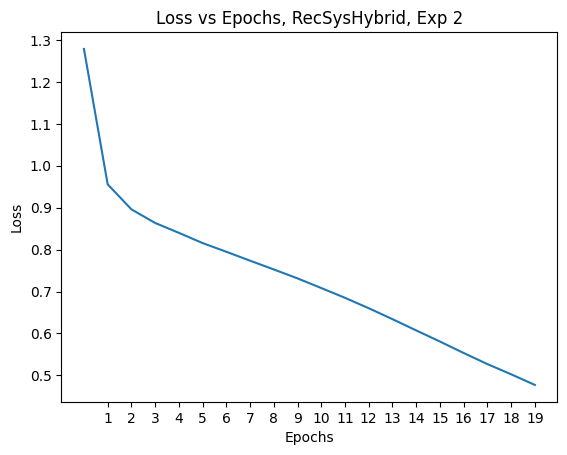

In [160]:
plot_training_epochs(losses_e2, "RecSysHybrid, Exp 2", 20)

In [161]:
get_mse_rmse_hybrid(model, test_ratings, test_users, test_items, test_genres, test_sentiments)

Test MSE: 1.087326814743484, Test RMSE: 1.0427496414497028


In [162]:
get_precision_at_k_hybrid(test_data, model, user_id_map, item_id_map, item_id_reverse_map, top_n=10)

Average Precision: 0.36852367688022286


0.36852367688022286

##### Exp 3: 50 embedding dim, 15 epochs

In [164]:
embedding_dim = 50
num_epochs = 15

model = HybridRecSys(num_users, num_items, num_genres, embedding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses_e3 = train_hybrid_recommender(model, train_dataloader, criterion, optimizer, num_epochs)

Epoch 1/15, Loss: 1.2177987092460056
Epoch 2/15, Loss: 0.9531057487067348
Epoch 3/15, Loss: 0.8962294584258563
Epoch 4/15, Loss: 0.861710723306705
Epoch 5/15, Loss: 0.8377815295109706
Epoch 6/15, Loss: 0.8126910126746324
Epoch 7/15, Loss: 0.7907243685097054
Epoch 8/15, Loss: 0.7683507385555046
Epoch 9/15, Loss: 0.748481922828662
Epoch 10/15, Loss: 0.7230046625254333
Epoch 11/15, Loss: 0.6990653219620067
Epoch 12/15, Loss: 0.6704029463177618
Epoch 13/15, Loss: 0.6400076747899658
Epoch 14/15, Loss: 0.6117475833848707
Epoch 15/15, Loss: 0.5823206483406687


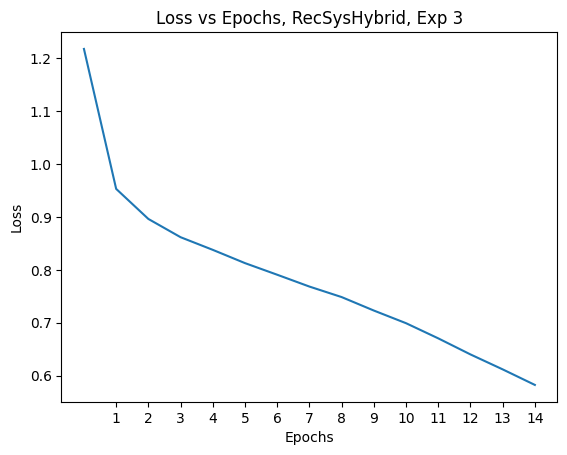

In [165]:
plot_training_epochs(losses_e3, "RecSysHybrid, Exp 3", 15)

In [166]:
get_mse_rmse_hybrid(model, test_ratings, test_users, test_items, test_genres, test_sentiments)

Test MSE: 1.0394425553417574, Test RMSE: 1.0195305563551087


In [167]:
get_precision_at_k_hybrid(test_data, model, user_id_map, item_id_map, item_id_reverse_map, top_n=10)

Average Precision: 0.36629526462395545


0.36629526462395545

##### Exp 4: 70 embedding dim, 10 epochs

In [168]:
embedding_dim = 70
num_epochs = 10

model = HybridRecSys(num_users, num_items, num_genres, embedding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses_e4 = train_hybrid_recommender(model, train_dataloader, criterion, optimizer, num_epochs)

Epoch 1/10, Loss: 1.2010028406390238
Epoch 2/10, Loss: 0.9354362751290574
Epoch 3/10, Loss: 0.8780438313058376
Epoch 4/10, Loss: 0.8468956448143754
Epoch 5/10, Loss: 0.8201080121441608
Epoch 6/10, Loss: 0.790189986040011
Epoch 7/10, Loss: 0.7617731532404141
Epoch 8/10, Loss: 0.7316660720162687
Epoch 9/10, Loss: 0.7023288438805436
Epoch 10/10, Loss: 0.6714042848573993


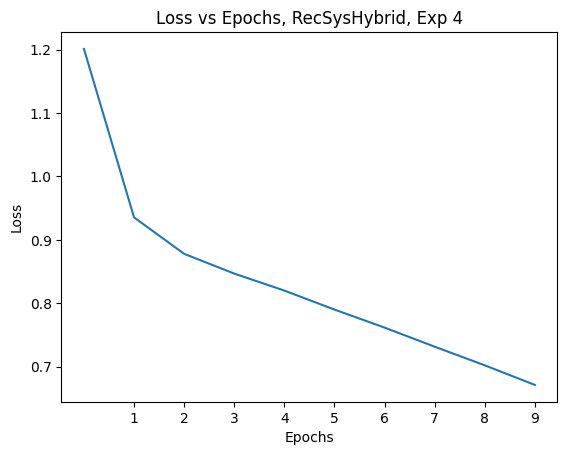

In [169]:
plot_training_epochs(losses_e4, "RecSysHybrid, Exp 4", 10)

In [170]:
get_mse_rmse_hybrid(model, test_ratings, test_users, test_items, test_genres, test_sentiments)

Test MSE: 0.9708485240382464, Test RMSE: 0.985316458828455


In [171]:
get_precision_at_k_hybrid(test_data, model, user_id_map, item_id_map, item_id_reverse_map, top_n=10)

Average Precision: 0.3816155988857939


0.3816155988857939

##### Exp 5: 30 embedding dim, 10 epochs

In [172]:
embedding_dim = 30
num_epochs = 10

model = HybridRecSys(num_users, num_items, num_genres, embedding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses_e5 = train_hybrid_recommender(model, train_dataloader, criterion, optimizer, num_epochs)

Epoch 1/10, Loss: 1.287923934089495
Epoch 2/10, Loss: 0.9799436366759474
Epoch 3/10, Loss: 0.9121306702818299
Epoch 4/10, Loss: 0.8768123850070557
Epoch 5/10, Loss: 0.8549800190058622
Epoch 6/10, Loss: 0.8374417896531612
Epoch 7/10, Loss: 0.8216222367359569
Epoch 8/10, Loss: 0.8099220137824383
Epoch 9/10, Loss: 0.7922412281734562
Epoch 10/10, Loss: 0.7790369600033625


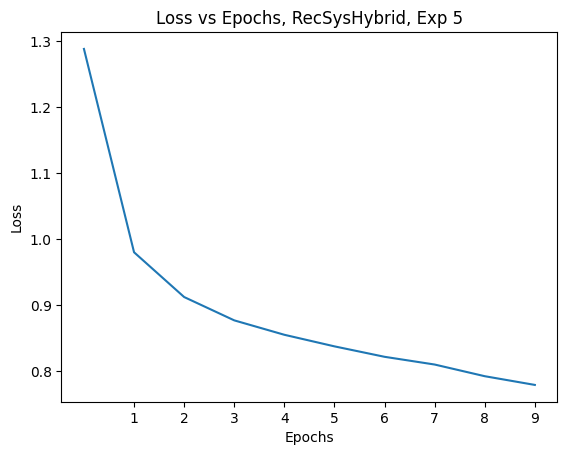

In [173]:
plot_training_epochs(losses_e5, "RecSysHybrid, Exp 5", 10)

In [174]:
get_mse_rmse_hybrid(model, test_ratings, test_users, test_items, test_genres, test_sentiments)

Test MSE: 0.9330476250966142, Test RMSE: 0.9659439037007347


In [175]:
get_precision_at_k_hybrid(test_data, model, user_id_map, item_id_map, item_id_reverse_map, top_n=10)

Average Precision: 0.38662952646239557


0.38662952646239557

##### Exp 6: 20 embedding dim, 10 epochs

In [176]:
embedding_dim = 20
num_epochs = 10

model = HybridRecSys(num_users, num_items, num_genres, embedding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses_e6 = train_hybrid_recommender(model, train_dataloader, criterion, optimizer, num_epochs)

Epoch 1/10, Loss: 1.3127687437248536
Epoch 2/10, Loss: 1.0049120322025695
Epoch 3/10, Loss: 0.9295686518867843
Epoch 4/10, Loss: 0.8906178617563731
Epoch 5/10, Loss: 0.8670078527035486
Epoch 6/10, Loss: 0.8492698917106957
Epoch 7/10, Loss: 0.8387361971102505
Epoch 8/10, Loss: 0.826188506182412
Epoch 9/10, Loss: 0.8179100180046269
Epoch 10/10, Loss: 0.8047956027815827


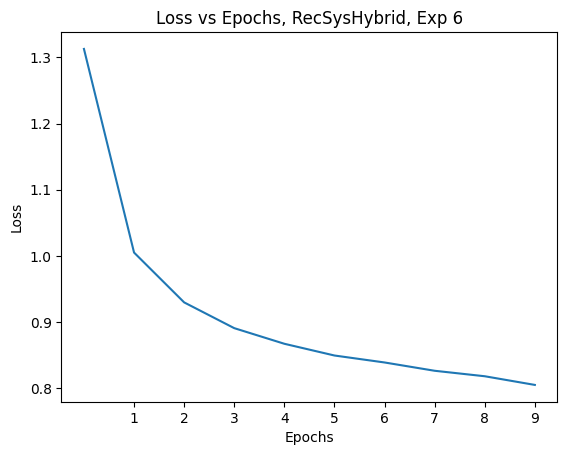

In [177]:
plot_training_epochs(losses_e6, "RecSysHybrid, Exp 6", 10)

In [178]:
get_mse_rmse_hybrid(model, test_ratings, test_users, test_items, test_genres, test_sentiments)

Test MSE: 0.912061100742144, Test RMSE: 0.955018900725082


In [179]:
get_precision_at_k_hybrid(test_data, model, user_id_map, item_id_map, item_id_reverse_map, top_n=10)

Average Precision: 0.39526462395543177


0.39526462395543177

##### Exp 7: 15 embedding dim, 10 epochs

In [181]:
embedding_dim = 15
num_epochs = 10

model = HybridRecSys(num_users, num_items, num_genres, embedding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses_e7 = train_hybrid_recommender(model, train_dataloader, criterion, optimizer, num_epochs)

Epoch 1/10, Loss: 1.3300073876653289
Epoch 2/10, Loss: 1.026905338177255
Epoch 3/10, Loss: 0.9480474907020744
Epoch 4/10, Loss: 0.9044734801338837
Epoch 5/10, Loss: 0.8803860902162876
Epoch 6/10, Loss: 0.8629794275914098
Epoch 7/10, Loss: 0.8495614120822134
Epoch 8/10, Loss: 0.837647451499922
Epoch 9/10, Loss: 0.8283713410098229
Epoch 10/10, Loss: 0.8203780734289681


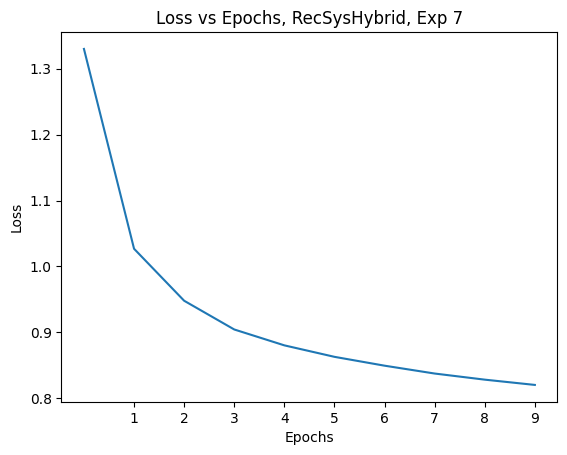

In [182]:
plot_training_epochs(losses_e7, "RecSysHybrid, Exp 7", 10)

In [183]:
get_mse_rmse_hybrid(model, test_ratings, test_users, test_items, test_genres, test_sentiments)

Test MSE: 0.9242897927544437, Test RMSE: 0.9613999130197817


In [184]:
get_precision_at_k_hybrid(test_data, model, user_id_map, item_id_map, item_id_reverse_map, top_n=10)

Average Precision: 0.3807799442896936


0.3807799442896936

## APPENDIX

Precision @10 industry standards:

Typical Precision Benchmarks by Domain
E-commerce:

Amazon, eBay, etc.: Precision@10 can range from 20% to 40%. High precision is crucial here as it directly impacts sales and user satisfaction.
Streaming Services:

Netflix, Spotify, etc.: Precision@10 often ranges from 25% to 50%. Recommendations significantly affect user engagement and retention.
Social Media:

Facebook, Twitter, etc.: Precision might be lower, ranging from 10% to 30%, due to the vast amount of diverse content and the focus on personalized feeds rather than precise recommendations.
News and Articles:

Google News, Flipboard, etc.: Precision can range from 15% to 35%. The goal is to keep users engaged with relevant articles.


References

[1] J. Bennett and S. Lanning, "The Netflix Prize," in Proceedings of KDD Cup and Workshop, 2007.

[2] G. Linden, B. Smith, and J. York, "Amazon.com Recommendations: Item-to-Item Collaborative Filtering," IEEE Internet Computing, vol. 7, no. 1, pp. 76-80, Jan.-Feb. 2003.

[3] A. Leino, "How Spotify Recommends Your New Favorite Artist," Spotify Engineering Blog, 2017. [Online]. Available: https://engineering.atspotify.com/2017/02/how-spotify-recommends-your-new-favorite-artist/

[4] M. J. Pazzani and D. Billsus, "Content-Based Recommendation Systems," in The Adaptive Web, P. Brusilovsky, A. Kobsa, and W. Nejdl, Eds. Berlin, Heidelberg: Springer-Verlag, 2007, pp. 325-341.